In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

cbf_colors = [
    '#0072B2',  # Blue
    '#009E73',  # Green
    '#CC79A7',  # Reddish purple
    '#F0E442',  # Yellow
    '#56B4E9',  # Light blue
    '#E69F00',  # Orange
    '#D55E00',  # Vermillion
    '#000000'   # Black
]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cbf_colors)

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=20)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

In [2]:
def stick_break_single_sample(beta_row):
    '''
    Convert Beta(1, alpha) draws to mixing proportions pi_k using
    truncated stick-breaking. Used on a single MCMC sample's beta_row.
    '''
    pi_list = []
    prod = 1.0
    for b_ in beta_row:
        part_ = b_ * prod
        pi_list.append(part_)
        prod *= (1.0 - b_)
    pi_list.append(prod)
    return np.array(pi_list)

def theta_HN(tau_array, tau0, phi):
    '''
    Helper function to compute the argument theta_HN(tau) for the HN DRT.
    '''
    return np.arctan2(
        np.sin(np.pi * phi),
        ((tau_array / tau0)**phi + np.cos(np.pi * phi))
    )

def hn_arc_impedance(freq_array, amplitude, phi, alpha, tau0):
    '''
    Single arc's impedance for HN:
      Z_arc = amplitude / [1 + (j*2πf * tau0)^phi]^alpha
    '''
    omega = 2.0 * np.pi * freq_array
    return amplitude / ((1.0 + (1j * omega * tau0)**phi) ** alpha)

def hn_arc_gamma(tau_array, amplitude, phi, alpha, tau0):
    '''
    Single arc's DRT for HN.
    gamma_HN = (amplitude / pi) * (tau/tau0)^(alpha*phi)*sin(alpha*theta)
               / [1 + 2*cos(pi*phi)*(tau/tau0)^phi + (tau/tau0)^(2phi)]^(alpha/2)
    where theta = arctan2(sin(pi*phi), ((tau/tau0)^phi + cos(pi*phi))).
    '''
    ratio_phi = (tau_array / tau0)**phi
    prefactor = amplitude / np.pi
    th = theta_HN(tau_array, tau0, phi)

    numerator = (tau_array / tau0)**(alpha * phi) * np.sin(alpha * th)
    denom = (1.0 + 2.0*np.cos(np.pi*phi)*ratio_phi + ratio_phi**2) ** (alpha/2.0)

    return prefactor * (numerator / denom)

In [3]:
def compute_posterior_arcs(freq_vec, tau_vec, posterior_samples):
    '''
    For each MCMC sample, compute:
      - K partial arcs in impedance space (HN),
      - K partial arcs in DRT space (HN),
      - sum across arcs plus R_inf.

    Returns arrays with shapes:
      all_arcs_impedance:    (n_samps, K, N_freq)
      all_arcs_gamma:        (n_samps, K, N_tau)
      sum_of_arcs_impedance: (n_samps, N_freq)
      sum_of_arcs_gamma:     (n_samps, N_tau)
      K:                     # of arcs used in the truncation.
    '''

    # Posterior arrays
    R_inf_samples    = posterior_samples['R_inf']
    beta_samples     = posterior_samples['beta_vals']
    w_samples        = posterior_samples['w_vals']
    phi_samples      = posterior_samples['phi_vals']
    alpha_samples    = posterior_samples['alpha_vals']
    log_tau_samples  = posterior_samples['log_tau_vals']

    n_samps = R_inf_samples.shape[0]
    K = w_samples.shape[1]

    all_arcs_impedance = []
    all_arcs_gamma     = []
    sum_of_arcs_impedance = []
    sum_of_arcs_gamma     = []

    for i in range(n_samps):
        R_inf_       = R_inf_samples[i]
        beta_row_    = beta_samples[i]
        w_vals_      = w_samples[i]
        phi_vals_    = phi_samples[i]
        alpha_vals_  = alpha_samples[i]
        tau_vals_    = np.exp(log_tau_samples[i])

        # Convert Beta draws to mixing proportions pi_ (shape (K,))
        pi_k = stick_break_single_sample(beta_row_)

        # Compute partial arcs
        arcs_Z_list = []
        arcs_gamma_list = []
        for k_idx in range(K):
            amplitude_k = pi_k[k_idx] * w_vals_[k_idx]
            phi_k       = phi_vals_[k_idx]
            alpha_k     = alpha_vals_[k_idx]
            tau0_k      = tau_vals_[k_idx]

            # Arc's impedance (HN)  #FC
            Z_k = hn_arc_impedance(freq_vec, amplitude_k, phi_k, alpha_k, tau0_k)
            arcs_Z_list.append(Z_k)

            # Arc's DRT (HN)       #FC
            g_k = hn_arc_gamma(tau_vec, amplitude_k, phi_k, alpha_k, tau0_k)
            arcs_gamma_list.append(g_k)

        # Stack them
        arcs_Z = np.stack(arcs_Z_list, axis=0)
        arcs_G = np.stack(arcs_gamma_list, axis=0)

        # Summation
        sum_imp = np.sum(arcs_Z, axis=0) + R_inf_
        sum_gam = np.sum(arcs_G, axis=0)

        all_arcs_impedance.append(arcs_Z)
        all_arcs_gamma.append(arcs_G)
        sum_of_arcs_impedance.append(sum_imp)
        sum_of_arcs_gamma.append(sum_gam)

    # Convert lists to arrays
    all_arcs_impedance    = np.stack(all_arcs_impedance,    axis=0)  # (n_samps, K, N_freq)
    all_arcs_gamma        = np.stack(all_arcs_gamma,        axis=0)  # (n_samps, K, N_tau)
    sum_of_arcs_impedance = np.stack(sum_of_arcs_impedance, axis=0)  # (n_samps, N_freq)
    sum_of_arcs_gamma     = np.stack(sum_of_arcs_gamma,     axis=0)  # (n_samps, N_tau)

    return (all_arcs_impedance, all_arcs_gamma,
            sum_of_arcs_impedance, sum_of_arcs_gamma, K)

Loads the frequency data, impedance data, exact references, tau array, exact gamma, and posterior samples from the HN-based analysis.

In [4]:
# Posterior samples
results_dir='dp_hn_results'
posterior_data = np.load(os.path.join(results_dir, 'posterior_samples.npy'), allow_pickle=True).item()

# Convert the posterior dictionary entries to arrays
posterior_samples = {}
for k, v in posterior_data.items():
    posterior_samples[k] = v

# EIS data and references
freq_vec     = np.load(os.path.join(results_dir, 'freq_vec.npy'))
Z_exp        = np.load(os.path.join(results_dir, 'Z_exp.npy'))
Z_exact      = np.load(os.path.join(results_dir, 'Z_exact.npy'))
tau_vec      = np.load(os.path.join(results_dir, 'tau_vec.npy'))
gamma_exact  = np.load(os.path.join(results_dir, 'gamma_exact.npy'))

In [5]:
(all_arcs_impedance, all_arcs_gamma, sum_of_arcs_impedance, sum_of_arcs_gamma, K) = compute_posterior_arcs(freq_vec, tau_vec, posterior_samples)
# Posterior mean for standard DRT plots
arcs_fit_mean_gam = np.mean(all_arcs_gamma, axis=0)         # (K, N_tau)
gamma_sum_mean    = np.mean(sum_of_arcs_gamma, axis=0)      # (N_tau,)

Plots the mean partial arcs and total DRT, with an option to overlay the exact DRT.

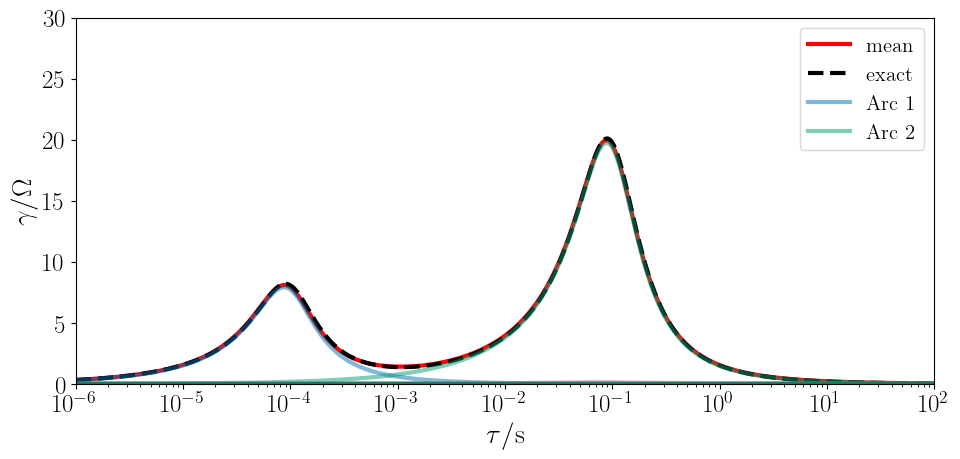

In [6]:
plt.figure(figsize=(10,5))
plt.semilogx(tau_vec, gamma_sum_mean, 'r-', linewidth=3, label='mean')
if gamma_exact is not None:
    plt.semilogx(tau_vec, gamma_exact, 'k--', linewidth=3, label='exact')

for k in range(arcs_fit_mean_gam.shape[0]):
    if k <= 1:
        plt.semilogx(tau_vec, arcs_fit_mean_gam[k], linewidth=3, alpha=0.5, label=f'Arc {k+1}')
    else:
        plt.semilogx(tau_vec, arcs_fit_mean_gam[k], linewidth=3, alpha=0.5)

plt.xlabel(r'$\tau/\rm s$')
plt.ylabel(r'$\gamma/\Omega$')
plt.legend(frameon=True, framealpha=0.75, fontsize=15)
plt.xlim(1e-6,1e2)
plt.ylim(0.0, 30)
# plt.title('DRT Components (Mean)')
plt.tight_layout()

# Save plots
# plt.savefig('gamma_components.png', format='png', dpi=300)
# plt.savefig('gamma_components.svg',)
plt.show()

Plots credible intervals (5%-95% and 25%-75%) of the total DRT, with an option to overlay an exact reference DRT.

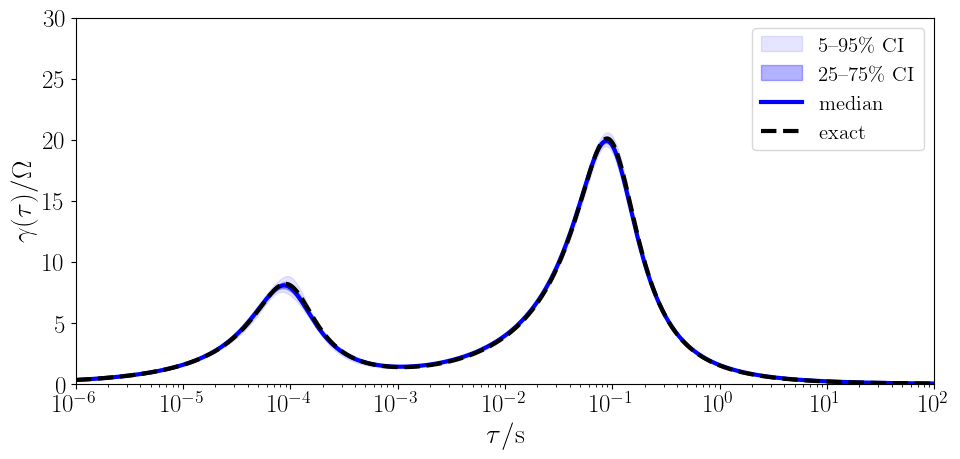

In [7]:
pct_vals = np.percentile(sum_of_arcs_gamma, [5, 25, 50, 75, 95], axis=0)
g5, g25, g50, g75, g95 = pct_vals

plt.figure(figsize=(10,5))
plt.fill_between(tau_vec, g5, g95, alpha=0.1, color='blue', label='5--95\\% CI')
plt.fill_between(tau_vec, g25, g75, alpha=0.3, color='blue', label='25--75\\% CI')
plt.semilogx(tau_vec, g50, 'b-', linewidth=3, label='median')
if gamma_exact is not None:
    plt.semilogx(tau_vec, gamma_exact, 'k--', linewidth=3, label='exact')
plt.xlabel(r'$\tau/\rm s$')
plt.ylabel(r'$\gamma(\tau)/\Omega$')
plt.xlim(1e-6,1e2)
plt.ylim(0.0, 30)
# plt.grid(True, which='both', alpha=0.3)
plt.legend(frameon=True, framealpha=0.75, fontsize=15)
# plt.title('Posterior Credible Intervals for Total DRT')
plt.tight_layout()

# plt.savefig('gamma_intervals.png', format='png', dpi=300)
# plt.savefig('gamma_intervals.svg',)
plt.show()

Nyquist plot of noisy data, exact model, and MCMC posterior mean.

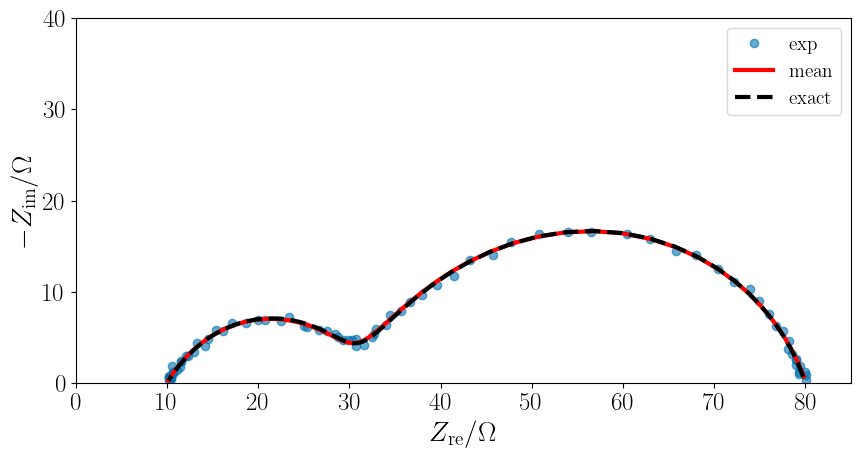

In [8]:
plt.figure(figsize=(10, 5))
# Plot the noisy experimental data
plt.plot(Z_exp.real, -Z_exp.imag, 'o', label='exp', alpha=0.6)
# Compute and plot the posterior mean
Z_mean = np.mean(sum_of_arcs_impedance, axis=0)
plt.plot(Z_mean.real, -Z_mean.imag, 'r-', label='mean', linewidth=3)
# Plot the exact noise-free data
plt.plot(Z_exact.real, -Z_exact.imag, 'k--', label='exact', linewidth=3)
# Label axes
plt.xlabel(r'$Z_{\rm re}/\Omega$')
plt.ylabel(r'$-Z_{\rm im}/\Omega$')
# Ensure equal aspect ratio
plt.gca().set_aspect(1)
# Set x and y axis limits
plt.xlim(0, 85)
plt.ylim(0, 40)

# # Set ticks at specific intervals
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80])
plt.yticks([0, 10, 20, 30, 40])

# Add legend
plt.legend(frameon=True, framealpha=0.75, fontsize=14)

# Save plots
# plt.savefig('nyquist_fit.png', format='png', dpi=300)
# plt.savefig('nyquist_fit.svg')
plt.show()

Bode plot of noisy data, exact model, and MCMC posterior mean.

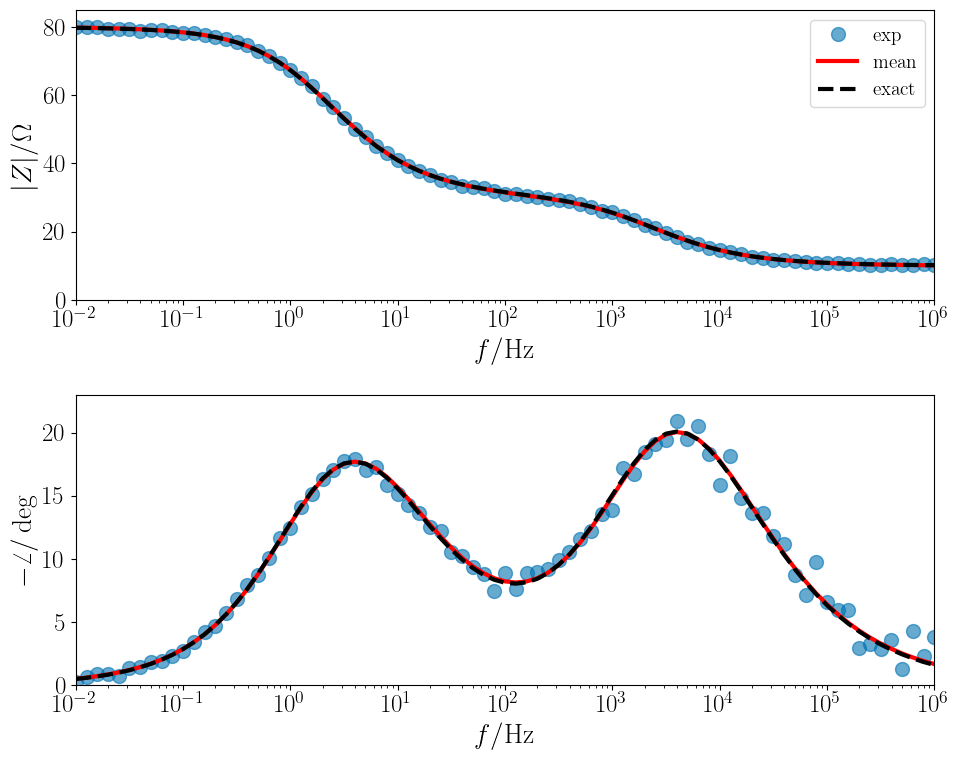

In [9]:
# Compute the posterior mean impedance
Z_mean = np.mean(sum_of_arcs_impedance, axis=0)

# Prepare magnitude (Ohms) and phase (degrees) for each quantity
mag_exp   = np.abs(Z_exp)
mag_exact = np.abs(Z_exact)
mag_mean  = np.abs(Z_mean)

phase_exp   = np.angle(Z_exp, deg=True)
phase_exact = np.angle(Z_exact, deg=True)
phase_mean  = np.angle(Z_mean, deg=True)

fig, (ax_mag, ax_phase) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# --- Magnitude subplot ---
ax_mag.semilogx(freq_vec, mag_exp,   'o',  label='exp',   alpha=0.6, markersize=10)
ax_mag.semilogx(freq_vec, mag_mean,  'r-', label='mean',  linewidth=3)
ax_mag.semilogx(freq_vec, mag_exact, 'k--',label='exact', linewidth=3)

ax_mag.set_xlabel(r'$f/\rm Hz$')
ax_mag.set_ylabel(r'$|Z|/\Omega$')

# Remove grid
# ax_mag.grid(True, which='both', alpha=0.75)  # Removed
ax_mag.legend(frameon=True, framealpha=0.75, fontsize=14)

# Set x and y range
ax_mag.set_xlim([1e-2, 1e6])
ax_mag.set_ylim([0, 85])
ax_mag.set_yticks([0, 20, 40, 60, 80])

# ax_mag.legend(frameon=True, framealpha=0.75, fontsize=14)

# --- Phase subplot ---
ax_phase.semilogx(freq_vec, -phase_exp,   'o',  label='exp',   alpha=0.6, markersize=10)
ax_phase.semilogx(freq_vec, -phase_mean,  'r-', label='mean',  linewidth=3)
ax_phase.semilogx(freq_vec, -phase_exact, 'k--',label='exact', linewidth=3)

ax_phase.set_xlabel(r'$f/\rm Hz$')
ax_phase.set_ylabel(r'$-\angle/\deg$')  # Modified label

# Set x range
ax_phase.set_xlim([1e-2, 1e6])
ax_phase.set_ylim([0, 23])
ax_phase.set_yticks([0, 5, 10, 15, 20])

# ax_phase.legend(frameon=True, framealpha=0.75, fontsize=14)

plt.tight_layout()
# plt.savefig('bode_fit.png', format='png', dpi=300)
# plt.savefig('bode_fit.svg',)
plt.show()